In [ ]:
import numpy as np
import math
import torch
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
classes = 100
train_total = 50000

#modified from: 
#https://github.com/kekmodel/FixMatch-pytorch/blob/master/dataset/cifar.py 
def x_u_split(labels, labeled_per_class):
    np.random.seed(0) #make sure split are the same
    labels = np.array(labels)
    labeled_idx = []
    for i in range(classes):
        idx = np.where(labels == i)[0]
        idx = np.random.choice(idx, labeled_per_class, False)
        labeled_idx.extend(idx)
    labeled_idx = np.array(labeled_idx)
    np.random.shuffle(labeled_idx)
    np.random.seed() #optionally restore rng
    return labeled_idx, np.setdiff1d(range(train_total), labeled_idx)

class CIFAR100SSL(datasets.CIFAR100):
    def __init__(self, root, indexs, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super().__init__(root, train=train,
                         transform=transform,
                         target_transform=target_transform,
                         download=download)
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


In [ ]:
mean,std = (0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)

transform_labeled = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

ResNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def train_model(model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer,
    scheduler = None):
  train_loss = []
  for epoch in range(num_epochs):
    time1 = time.time()
    model.train()
    total_loss = 0
    for data, target in l_train_dataloader:
      optimizer.zero_grad()
      if gpu_boole:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      total_loss += loss.item()
      optimizer.step()
    if scheduler is not None:
      scheduler.step()
    train_loss.append(total_loss/len(l_train_dataloader))

    model.eval()
    correct_sum = 0
    with torch.no_grad():
      for data, target in test_dataloader:
        if gpu_boole:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct_sum += (predicted.float() == target.float()).sum().item()
    correct_sum2 = 0
    with torch.no_grad():
      for data, target in l_train_dataloader:
        if gpu_boole:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct_sum2 += (predicted.float() == target.float()).sum().item()
    time2 = time.time()
    print('epoch:', epoch+1, ' train loss:', total_loss/len(l_train_dataloader), \
          'train accuracy:', correct_sum2/len(train_labeled_dataset),\
          'val accuracy:', correct_sum/len(test_dataset))
    print('ETA of completion:',(time2 - time1)*(num_epochs - epoch - 1)/60,'minutes')

  plt.plot(train_loss, label = 'training loss')
  plt.xlabel('Epoch Number')
  plt.ylabel('Average Traning Loss At Each Epoch')
  plt.legend()
  plt.title('Training Loss vs Epochs')
  plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


5 per class, 500 in total, 1:99

In [ ]:
root = './tmp'
#adjust this for labeled and unlabed split
labeled_per_class = 5

base_dataset = datasets.CIFAR100(
    root, train=True, download=True)

train_labeled_idxs, train_unlabeled_idxs = x_u_split(base_dataset.targets, labeled_per_class)

train_labeled_dataset = CIFAR100SSL(
    root, train_labeled_idxs, train=True,
    transform=transform_labeled)

test_dataset = datasets.CIFAR100(
    root, train=False, transform=transform_test, download=False)

batch_size = 128
l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./tmp/cifar-100-python.tar.gz to ./tmp


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 1  train loss: 4.8311227560043335 train accuracy: 0.074 val accuracy: 0.0299
ETA of completion: 2.8466288208961488 minutes
epoch: 2  train loss: 4.11580628156662 train accuracy: 0.154 val accuracy: 0.0588
ETA of completion: 2.2337482452392576 minutes
epoch: 3  train loss: 3.203149974346161 train accuracy: 0.318 val accuracy: 0.0882
ETA of completion: 2.2079611817995706 minutes
epoch: 4  train loss: 2.0544279515743256 train accuracy: 0.53 val accuracy: 0.1004
ETA of completion: 2.126038138071696 minutes
epoch: 5  train loss: 1.2230151891708374 train accuracy: 0.722 val accuracy: 0.1048
ETA of completion: 2.084385931491852 minutes
epoch: 6  train loss: 0.6955825388431549 train accuracy: 0.806 val accuracy: 0.1057
ETA of completion: 2.0559779326121013 minutes
epoch: 7  train loss: 0.41866350173950195 train accuracy: 0.902 val accuracy: 0.1162
ETA of completion: 2.026152777671814 minutes
epoch: 8  train loss: 0.24203263595700264 train accuracy: 0.944 val accuracy: 0.1242
ETA of comp

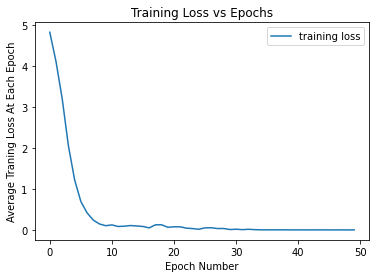

In [ ]:
lr = 0.001
num_epochs = 50

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, classes)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer,
    scheduler)
torch.save(model.state_dict(), '/content/drive/MyDrive/JHU_courses/MLDL/Final Project/MLDL/cifar/model/100_baseline_ResNet_Harry.pth')

50 per class, 5000 in total, 1:9

In [ ]:
root = './tmp'
#adjust this for labeled and unlabed split
labeled_per_class = 100

base_dataset = datasets.CIFAR100(
    root, train=True, download=True)

train_labeled_idxs, train_unlabeled_idxs = x_u_split(base_dataset.targets, labeled_per_class)

train_labeled_dataset = CIFAR100SSL(
    root, train_labeled_idxs, train=True,
    transform=transform_labeled)

test_dataset = datasets.CIFAR100(
    root, train=False, transform=transform_test, download=False)

batch_size = 128
l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Files already downloaded and verified


epoch: 1  train loss: 3.6727548550955857 train accuracy: 0.2438 val accuracy: 0.2059
ETA of completion: 9.518631605307261 minutes
epoch: 2  train loss: 2.6660974176624155 train accuracy: 0.4259 val accuracy: 0.3374
ETA of completion: 9.230148887634277 minutes
epoch: 3  train loss: 2.3282798709748667 train accuracy: 0.421 val accuracy: 0.312
ETA of completion: 8.956552104155223 minutes
epoch: 4  train loss: 2.1069501230988323 train accuracy: 0.5781 val accuracy: 0.3965
ETA of completion: 8.841633439064026 minutes
epoch: 5  train loss: 1.6541536125955703 train accuracy: 0.6101 val accuracy: 0.3796
ETA of completion: 8.714892446994781 minutes
epoch: 6  train loss: 1.5096117227892332 train accuracy: 0.7174 val accuracy: 0.4215
ETA of completion: 8.452914921442668 minutes
epoch: 7  train loss: 1.28552416985548 train accuracy: 0.7509 val accuracy: 0.4295
ETA of completion: 8.249933024247488 minutes
epoch: 8  train loss: 1.4570045931429803 train accuracy: 0.6949 val accuracy: 0.3828
ETA of co

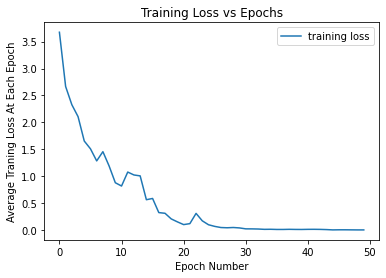

In [ ]:
lr = 0.001
num_epochs = 50

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, classes)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer,
    scheduler)
torch.save(model.state_dict(), '/content/drive/MyDrive/JHU_courses/MLDL/Final Project/MLDL/cifar/model/100_20%_baseline_ResNet_Harry.pth')